# 一、背景
天猫订单综合分析，数据来源于天猫真实成交订单，时间为2020年2月份。

# 二、理解数据
本数据集共收集了发生在一个月内的28010条数据，包含以下：

['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间 ', '退款金额']

7个字段说明：

1.订单编号：订单编号；


2.总金额：订单总金额；

3.买家实际支付金额：总金额 - 退款金额（在已付款的情况下）。金额为0（在
未付款的情况下）；

4.收货地址：各个省份；

5.订单创建时间：下单时间；

6.订单付款时间：付款时间，如无付款，则值为空；

7.退款金额：付款后申请退款的金额。如无付过款，退款金额为0。

# 三、提出问题
1.订单每个环节的转化率

2.订单成交的时间（按天）趋势(按实际成交）

3.订单数在地图上的分布

# 四、数据清洗

In [2]:
# 导入pandas，pyecharts包
import pandas as pd
from pyecharts.charts import *
import pyecharts.options as opt

In [4]:
# 读取要清洗分析的csv文件，并浏览数据

df = pd.read_csv('./tmall_order_report.csv')
df

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
0,1,178.8,0.0,上海,2020-02-21 00:00:00,NaN,0.0
1,2,21.0,21.0,内蒙古自治区,2020-02-20 23:59:54,2020-02-21 00:00:02,0.0
2,3,37.0,0.0,安徽省,2020-02-20 23:59:35,NaN,0.0
3,4,157.0,157.0,湖南省,2020-02-20 23:58:34,2020-02-20 23:58:44,0.0
4,5,64.8,0.0,江苏省,2020-02-20 23:57:04,2020-02-20 23:57:11,64.8
...,...,...,...,...,...,...,...
28005,28006,37.0,37.0,四川省,2020-02-27 00:01:00,2020-02-27 00:01:10,0.0
28006,28007,69.0,0.0,上海,2020-02-27 00:00:18,NaN,0.0
28007,28008,69.0,0.0,上海,2020-02-27 00:00:17,NaN,0.0
28008,28009,37.0,37.0,辽宁省,2020-02-27 00:00:09,2020-02-27 00:00:17,0.0


In [5]:
# 检查字段名称是否有问题
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址 ', '订单创建时间', '订单付款时间 ', '退款金额'], dtype='object')

In [6]:
# 发现有两个字段名称末尾含有空格，重命名字段名，inplace=True意思是在原来的表格上更改 
df.rename(columns={'收货地址 ':'收货地址','订单付款时间 ':'订单付款时间'},inplace=True)
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间', '退款金额'], dtype='object')

In [7]:
# 检查是否有重复值，结果无，无需处理

df.duplicated().sum()

0

In [8]:
# 检查是否有空值，发现只有订单付款时间字段有空值，原因是用户只下单并未付款，未付款订单数为3923，由于不用计算该字段的值，这里的空值不做任何处理

df.isnull().sum()

订单编号           0
总金额            0
买家实际支付金额       0
收货地址           0
订单创建时间         0
订单付款时间      3923
退款金额           0
dtype: int64

In [9]:
# 查看数据的属性，发现订单编号数据类型为数值，订单创建时间和订单付款时间的值为字符串，还得知不是空值的订单付款时间的值有24087个，则付款的订单数为24087

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28010 entries, 0 to 28009
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   订单编号      28010 non-null  int64  
 1   总金额       28010 non-null  float64
 2   买家实际支付金额  28010 non-null  float64
 3   收货地址      28010 non-null  object 
 4   订单创建时间    28010 non-null  object 
 5   订单付款时间    24087 non-null  object 
 6   退款金额      28010 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ MB


In [10]:
# 一致化处理数据类型，并清洗字符串，利于接下来的地图可视化分析

df['订单编号'] = df['订单编号'].astype(str)
df['订单创建时间'] = pd.to_datetime(df['订单创建时间'].str[:10])
df['订单付款时间'] = pd.to_datetime(df['订单付款时间'].str[:10])

In [11]:
df['收货地址'] = df['收货地址'].str.replace('省','').str.replace('自治区','')
def strs(x):
    if len(str(x)) > 3:
        x = x[:2]
    else:
        pass
    return x
df['收货地址'] = df['收货地址'].apply(strs)

In [12]:
df = df.sort_values('订单创建时间', ascending=True).reset_index(drop=True)
df

# 处理完成的数据如下

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
0,5922,38.0,38.0,上海,2020-02-01,2020-02-01,0.0
1,5953,38.0,38.0,上海,2020-02-01,2020-02-01,0.0
2,5952,38.0,38.0,上海,2020-02-01,2020-02-01,0.0
3,5951,38.0,0.0,广东,2020-02-01,2020-02-01,38.0
4,5949,76.0,0.0,吉林,2020-02-01,2020-02-01,76.0
...,...,...,...,...,...,...,...
28005,22036,69.0,69.0,江苏,2020-02-29,2020-02-29,0.0
28006,22037,85.0,85.0,江苏,2020-02-29,2020-02-29,0.0
28007,22038,116.0,116.0,河北,2020-02-29,2020-02-29,0.0
28008,22024,83.0,83.0,北京,2020-02-29,2020-02-29,0.0


In [13]:
# 使用描述统计分析数据有无异常值

df.describe()

,总金额,买家实际支付金额,退款金额
count,28010.000000,28010.000000,28010.000000
mean,106.953253,67.921712,20.433271
std,1136.587094,151.493434,71.501963
min,1.000000,0.000000,0.000000
25%,38.000000,0.000000,0.000000
50%,75.000000,45.000000,0.000000
75%,119.000000,101.000000,0.000000
max,188320.000000,16065.000000,3800.000000


从分析结果来看，数据并无异常值，并且可以发现，未退款和未付款的总共超过75%，而退全款和未付款的总共超过25%，而且根据标准差和平均值分析得知，数据整体波动幅度较大。

# 五、数据分析
## 1.订单每个环节的转化率分别是多少？（用户行为分析——漏斗分析）

用户行为流程图：

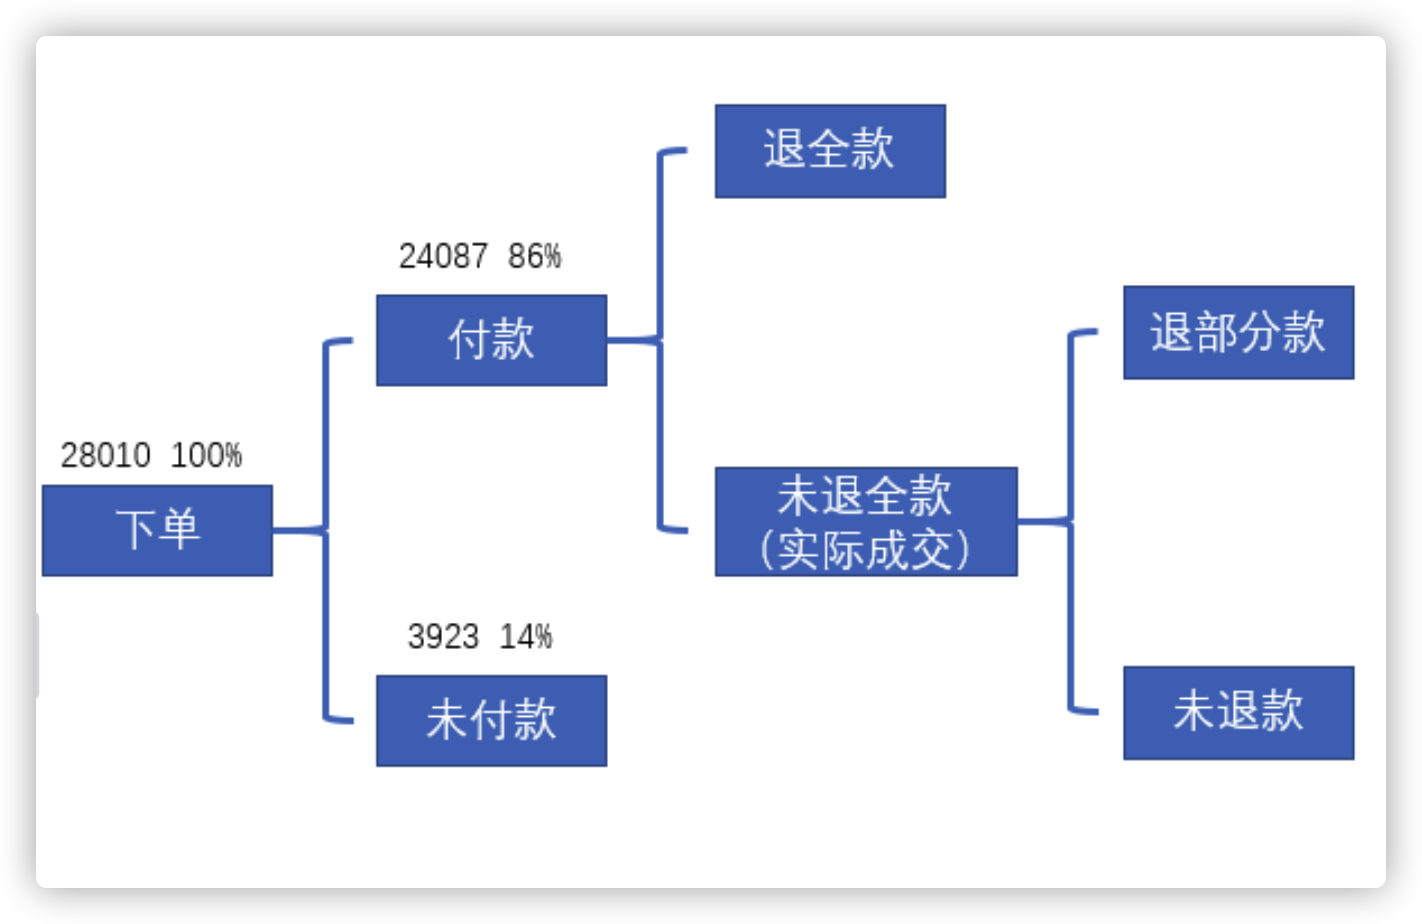

In [16]:
from IPython.display import Image
Image(filename = './用户行为流程图.png', width=500, height=300)

In [17]:
# 已知下单数：28010，未付款订单数：3923，付款订单数：24087，计算其他每个环节的订单数

df1 = df[df['总金额']==df['退款金额']]            # 由于用户退全款，则退款金额等于总金额
print('退全款订单数：',df1['订单编号'].count())

退全款订单数： 5132


In [18]:
df2 = df[(df['买家实际支付金额'] != 0) & (df['退款金额'] != 0)]    # 由于用户只退部分款，则买家实际支付金额不等于0，且退款金额也不等于0
print('退部分款订单数：', df2['订单编号'].count())

退部分款订单数： 514


In [19]:
df3 = df[df['总金额'] == df['买家实际支付金额']]    # 由于用户未退款，则总金额等于买家实际支付金额
print('未退款订单数：', df3['订单编号'].count())

未退款订单数： 18441


In [20]:
print('实际成交订单数：', df2['订单编号'].count()+df3['订单编号'].count())  # 实际成交订单数=未退款订单数+退部分款订单数

实际成交订单数： 18955


通过计算，每个环节的转化率分别为：

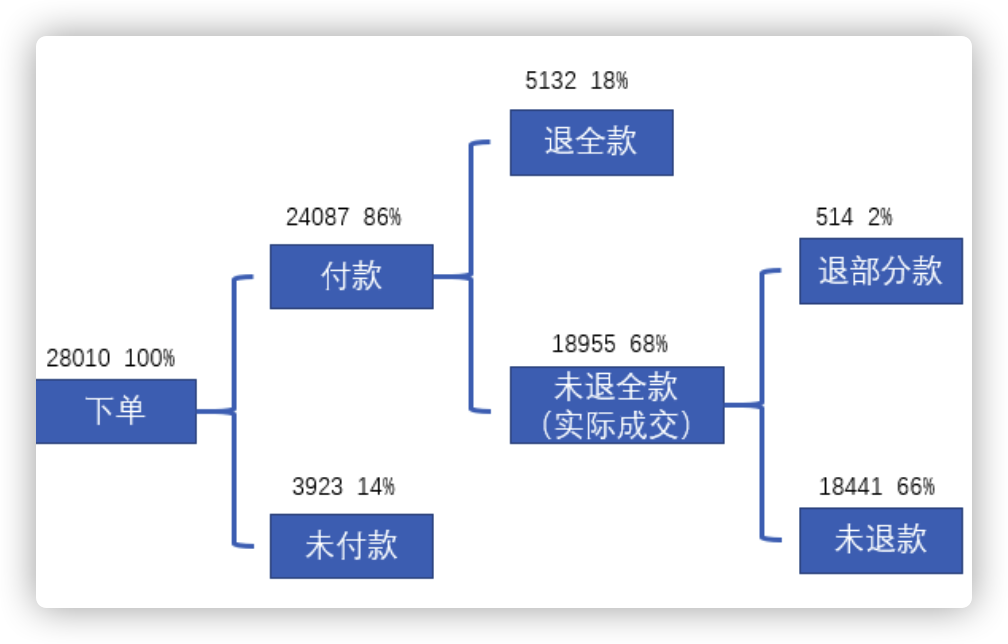

In [21]:
Image(filename = './完成的流程图.png', width=500, height=300)

实际成交转化率漏斗图：

In [22]:
list1 = ['下单 100%','付款 86%', '未退全款 68%', '未退款 66%']
list2 = ['28010', '24087', '18955', '18441']
funnel = (
    Funnel()
    .add(series_name='订单数', data_pair=list(zip(list1,list2)), label_opts = opt.LabelOpts(position = 'inside'))
)
funnel.render_notebook()

通过流程图和漏斗图分析，全款成交（未退款）的转化率不到下单总数的四分之三，主要原因是用户未付款和退全款导致的，那么可以猜测未付款的用户可能由于在付款界面出了一些问题，比如付款页面不友好，不够简洁，或者页面出现崩溃付不了款等等，至于退全款的用户可能是由于商品质量出现问题或没效果，收到的实物与商品描述不符，售后服务不好等等这些问题，但是由于数据有限，无法一一使用相应的数据证明这些假设原因是否成立，以上猜测结论仅供参考。

## 2.订单成交的时间（按天）趋势(按实际成交）变化情况

In [23]:
df4 = df[df['买家实际支付金额'] != 0]   # 实际成交的条件是买家实际支付金额不等于0
df4

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
0,5922,38.0,38.0,上海,2020-02-01,2020-02-01,0.0
1,5953,38.0,38.0,上海,2020-02-01,2020-02-01,0.0
2,5952,38.0,38.0,上海,2020-02-01,2020-02-01,0.0
5,5948,104.0,104.0,黑龙江,2020-02-01,2020-02-01,0.0
6,5947,38.0,38.0,上海,2020-02-01,2020-02-01,0.0
...,...,...,...,...,...,...,...
28005,22036,69.0,69.0,江苏,2020-02-29,2020-02-29,0.0
28006,22037,85.0,85.0,江苏,2020-02-29,2020-02-29,0.0
28007,22038,116.0,116.0,河北,2020-02-29,2020-02-29,0.0
28008,22024,83.0,83.0,北京,2020-02-29,2020-02-29,0.0


In [24]:
s = df4['订单编号'].groupby(df4['订单付款时间']).count()   # 按天分组汇总订单数

In [25]:
line = (
    Line().add_xaxis(s.index.tolist()).add_yaxis('订单数', s.values.tolist())
)
line.render_notebook()

从实际成交订单数按天变化的趋势情况来看（可用鼠标指针移动到每个节点查看数据），2月份上半月的销售情况并不理想，而下半月的整体销售情况较好，通过查看该月份的节假日情况发现，2月份上半月基本还是处于春节期间，可能大部分商家暂停营业放假过节，并且根据快递公司的营业情况得知快递公司基本都在春节期间暂停营业放假过年，所以这是导致2月份上半月销量较低的原因之一，当下半月快递公司逐渐开始营业，销量情况也逐渐好了起来，至于到了三月份初第一天为什么下降这么多，或许是由于春节优惠活动已经结束了，但这得看三月份的销售情况数据才能得知具体原因。

## 3.订单数在地图上的分布情况


In [26]:
s1 = df4['订单编号'].groupby(df4['收货地址']).count()
maps = (Map()
       .add(series_name='订单数',data_pair=list(zip(s1.index.tolist(), s1.values.tolist())))
       .set_global_opts(visualmap_opts=opt.VisualMapOpts(max_=max(s1)*0.6)))
maps.render_notebook()

从地图中可以看到（可用鼠标指针移动到地图相应位置查看数据），北京，山东，上海，江苏，浙江，四川和广东这些地区销量较好，可能由于这些地区人口较多，消费较多，需求也较多。没有数据可以证明是否也是原因之一，所以结论仅供参考。

# 六、总结
本文天猫订单数据分析主要使用Python进行数据清洗和数据可视化分析，在以上分析中使用漏斗分析方法和计算得知，未付款和退全款的转化率加起来超过了四分之一，可能的原因已在上面分析说明，但导致这情况发生的具体原因还是需要更多的其他方面数据才能进行深入分析，还有2月份上半月销售情况不好的原因之一是根据节假日情况和快递公司营业情况可得知在春节期间大部分商家和快递公司放假暂停营业，但具体是不是主要原因还需其他数据分析才能得知答案，最后使用地图可视化分析哪些地区销售较好。